# DTS and CSAT $T_{air}$

__Problem Statement__:
The DTS temperatures are subject to errors, most notably
- solar heating during the day
- radiative cooling at night
- and a convective heat flux that depends on the difference between the fiber and air temperature and the strength of the wind speed

The CSATs give high precision, low accuracy $T_{air}$. It is necessary to understand how the CSATs compare to each other in order to derive some basic quantities and enable cross-comparisons.

These three factors are all interrelated and have spatially-varying properties (e.g., as wind speed varies with height).

__Goals of Notebook__:
- Investigate the systemic errors in the CSAT air temperature 
- Understand which conditions lead to errors in DTS Tair
- Provide ground work for correcting these using clusters

# 1. Import and formatting

In [23]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
import warnings
import itertools

# Clustering/dimensionality reduction
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

## Format plots

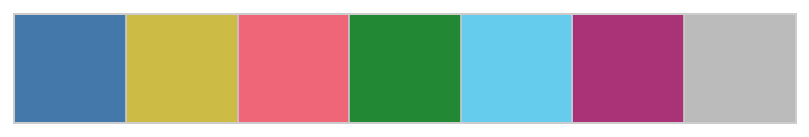

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))
sns.palplot(tol_bright_reorder)

## Directories

In [3]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_press = os.path.join(dir_logger_data, 'pressure')
dir_bayes_glm = os.path.join(dir_pre, 'love_dts', 'bayes_glm')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized data

Use the homogenized data from `homogenizing-stability-data.ipynb`

In [4]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta = xr.open_dataarray('aws_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta_10min = xr.open_dataarray('aws_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v1-2021-02-22.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')


## 2.2 Tower 10min Bayesian modeling output

In [5]:
os.chdir(dir_bayes_glm)
tower_10min = xr.open_dataset('tower_10min_bayes_glm.nc')

## 2.2 Ceilometer, AWS, and pressure data

- Ceilometer for cloudiness
- AWS for radiation and RH
- pressure for potential temperature calculations

In [6]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min.time, method='nearest')
ceilo_10min = ceilo.interp_like(tower_10min.time, method='nearest')

In [7]:
os.chdir(dir_aws_data)
aws_10min = xr.open_dataset('AWS_Voi_10min.nc')

## 2.3 Create a gappy version of the 10min DTS tower data

In [9]:
dt = pd.date_range(
    start=pd.Timestamp(tower_10min.time[0].values),
    end=pd.Timestamp(tower_10min.time[-1].values),
    freq='10min',
)

tower_10min_nanfill = tower_10min.reindex(time=dt, tolerance=1, method='nearest')

Periods with obvious sublayers are still fairly porrly fit. But in general this gives the results I would intuitively expect.

# 3. Evaluate the CSAT temperatures

CSAT sonic temperatures were converted to air temperature in the homogenization data preparation script. During neutrally stable conditions, we would expect that the CSATs should also have a flat/neutral profile. Any deviation away from neutral is indicative of a bias. Using this logic we can bias correct our CSATs after the fact. While a rigorous instrument intercomparison pre- or post-campaign would have been preferable, this approach will reduce the uncertainty in the CSAT temperatures substantially.

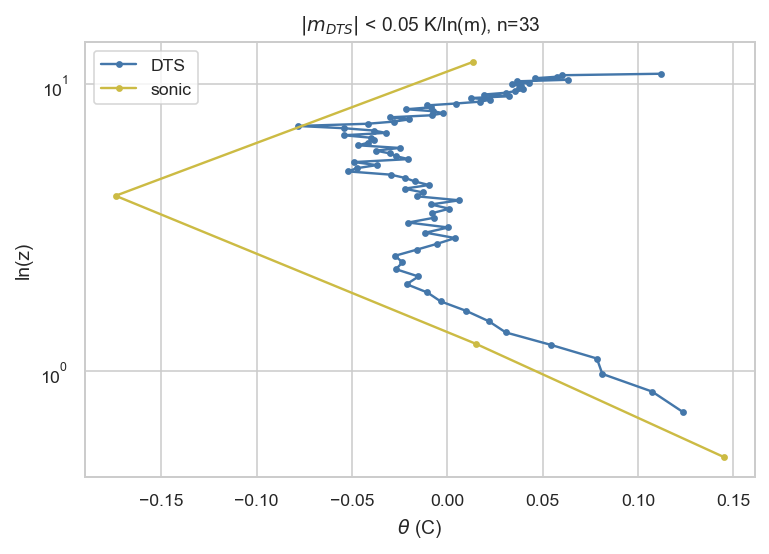

In [10]:
ind = (tower_10min.b1_slope.mean(dim='draws') < 0.05) & (tower_10min.b1_slope.mean(dim='draws') > -0.05)

fig, ax = plt.subplots(1, 1)

ax.semilogy(
    tower_10min.theta_mean_norm.where(ind).mean(dim='time'), 
    tower_10min.z,
    marker='.',
    label='DTS'
)
ax.semilogy(
    sonic_10min.theta.where(ind).mean(dim='time') - sonic_10min.theta.where(ind).mean(dim='time').swap_dims({'names': 'z'}).mean(dim='z'),
    sonic_10min.z,
    marker='.',
    label='sonic'
)

ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$\theta$ (C)')
ax.set_title(r'$|m_{{DTS}}|$ < 0.05 K/ln(m), n={}'.format(ind.sum(dim='time').values))
ax.legend()

The shape of the sonics and DTS seems to align overall. But, given the results above, I am left wondering how much these results are informed by periods with poor linear fits from artifacts from the fiber holders at the top and bottom of the profiles.

Artifacts can be largely removed by imposing the restriction that cloud cover is nearly complete, which reduces the occurrence of radiative artifacts.

Let's select for periods where I have greater confidence in the DTS signal giving us a neutral boundary layer with the additional constraint that the total cloud cover >= 7/8 (as observed by the ceilometer).

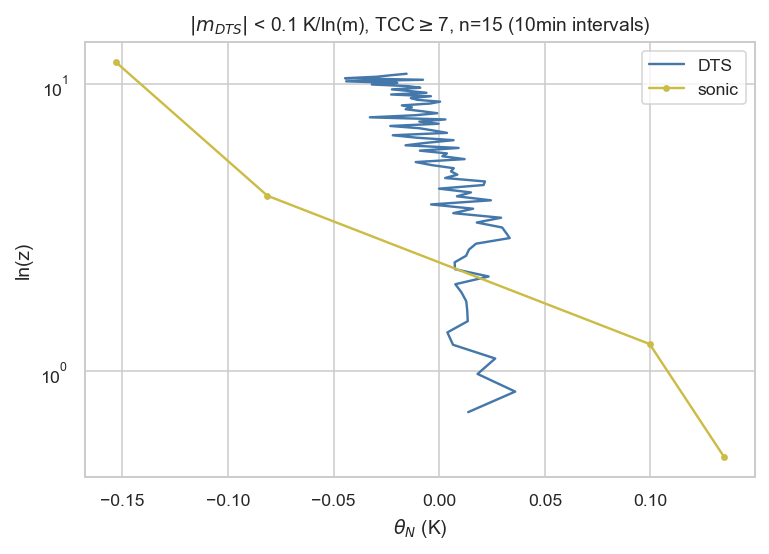

In [11]:
ind = (tower_10min.b1_slope.mean(dim='draws') < 0.05) & (tower_10min.b1_slope.mean(dim='draws') > -0.05) & (ceilo_10min.tcc >= 7)

fig, ax = plt.subplots(1, 1)

ax.semilogy(
    tower_10min.theta_mean_norm.where(ind).mean(dim='time'),
    tower_10min.z,
    label='DTS')
ax.semilogy(
    sonic_10min.theta.where(ind).mean(dim='time') - sonic_10min.theta.where(ind).mean(dim='time').mean(dim='names'),
    sonic_10min.z,
    marker='.',
    label='sonic'
)

ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$\theta_{N}$ (K)')
ax.set_title(r'$|m_{{DTS}}|$ < 0.1 K/ln(m), TCC$\geq$7, n={} (10min intervals)'.format(ind.sum(dim='time').values))
ax.legend()

Here there is still an offset, which is not a huge deal. There is a bit more of the shape I expected based on my experience, of a slight warm bias near the surface and maybe a slight cold bias aloft, all of which are around 0.2K at most. However, this is still not very informative. And is the restriction of cloud cover or a small sensible heat flux or strong winds really going to give a good discriminator for neutral conditions inferred through the DTS? Or am I accidentally selecting for periods with less neutral conditions and compensating errors?


# 4. Evaluating the DTS against the standard reference temperature on the AWS

What sort of disagreement is there between the AWS and tower DTS(z=2m) at 10minute scales? At this scale I would expect field scale variations to be minimized (but not completely gone!).

In [12]:
# Select the nearest z-coordinate along the tower to compare to the AWS
tower_2m_10min = tower_10min.swap_dims({'xyz': 'z'}).sel(z=2, method='nearest').theta_mean


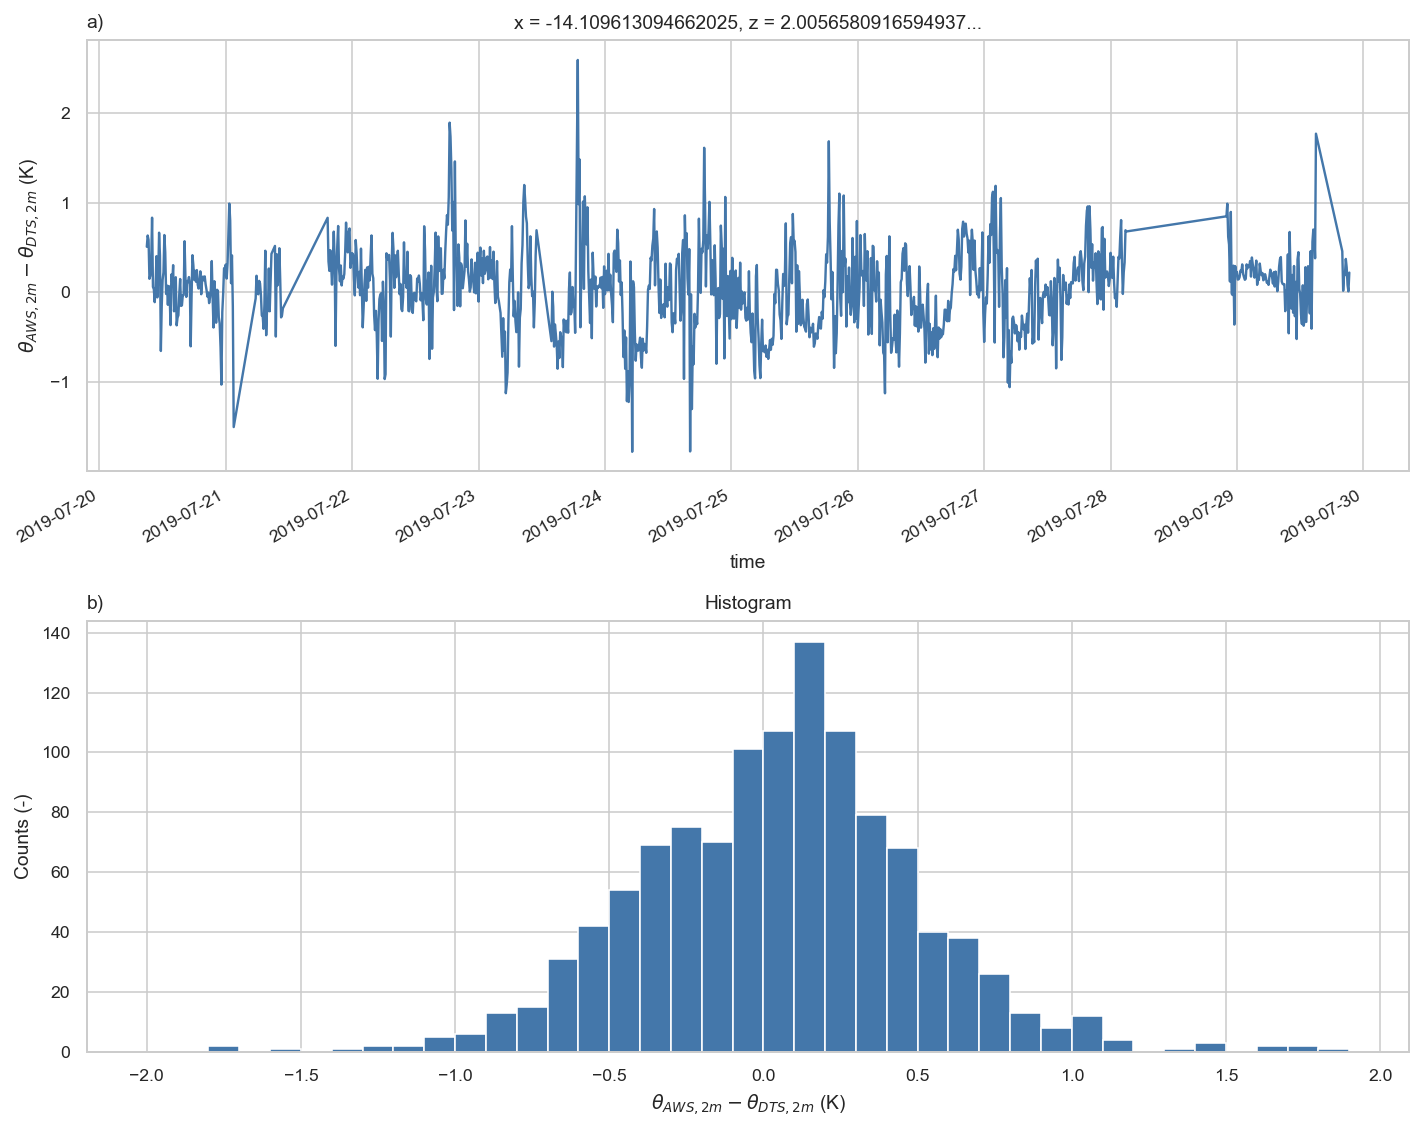

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
(aws_2m_theta_10min - tower_2m_10min).plot(ax=ax)
ax.set_ylabel(r'$\theta_{AWS, 2m} - \theta_{DTS, 2m}$ (K)')
ax.set_title('a)', loc='left')

ax = axes[1]
(aws_2m_theta_10min - tower_2m_10min).plot.hist(ax=ax, bins=np.arange(-2, 2, 0.1))
ax.set_xlabel(r'$\theta_{AWS, 2m} - \theta_{DTS, 2m}$ (K)')
ax.set_title('b)', loc='left')
ax.set_ylabel('Counts (-)')

fig.tight_layout()

Generally there is a small positive bias. I bet that coincides with periods of solar heating. I can convince myself there is a second, smaller negative distribution, which should correspond to radiative cooling at night. I also wonder how this temperature difference corresponds to the temperature gradient (e.g., are we predisposed to a positive gradient when the temperature difference is positive?). There are a lot of interacting variables here... let's just visualize all of them at once.

# 5. Factors that contribute to DTS air temperature errors

Next is to look at the join distributions of cloud cover, Qh, potential temperature, gradient slope (both DTS and sonic), wind speed, LWdwn, SWdwn, and LWnet.

## 5.1 prepare data

First, let's create a data label for each interval to use when labeling the pair plots.

In [14]:
ds = copy.deepcopy(tower_10min)
ds['interval'] = (('time'), np.zeros_like(ds.ols_m))
ds['interval'] = ds['interval'].where((ds['time.hour'] > 5) & (ds['time.hour'] <= 22), 'night')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 5) | (ds['time.hour'] >= 9), 'morning')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 9) | (ds['time.hour'] >= 15), 'day')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 15) | (ds['time.hour'] > 22), 'evening')

Then convert everything to pandas.

In [16]:
ds_10min = xr.merge(
    [
        sonic_10min.theta.sel(names='4m').rename('theta_sonic_4m').drop('z'),
        sonic_10min.wTs.sel(names='4m').rename('wTs_sonic_4m').drop('z'),
        sonic_10min.U_scalar_mean_rot.sel(names='4m').rename('U_sonic_4m').drop('z'),
        tower_10min.b1_slope.mean(dim='draws'),
        ceilo_10min.tcc,
        (aws_2m_theta_10min - tower_2m_10min).rename('theta_diff'),
        aws_2m_theta_10min.rename('AWS_theta_2m'),
        aws_10min['Rlwd (CNR4)'].rename('LWdwn'),
        (aws_10min['Rlwd (CNR4)'] - aws_10min['Rlwu (CNR4)']).rename('LWnet'),
        aws_10min['Rswd (CNR4)'].rename('SWdwn'),
        tower_2m_10min.rename('dts_theta_2m').drop('z'),
        ds['interval'],
    ],
)
df_10min = xr.Dataset.to_dataframe(
    ds_10min.drop(
        [
            'x', 'z', 'LAF',
            'northcones', 'unheated',
            'southcones', 'y',
            'heated', 'eastcones'
        ],
    errors='ignore',
    )
)

## 5.2 Distribution of errors with meteorological conditions

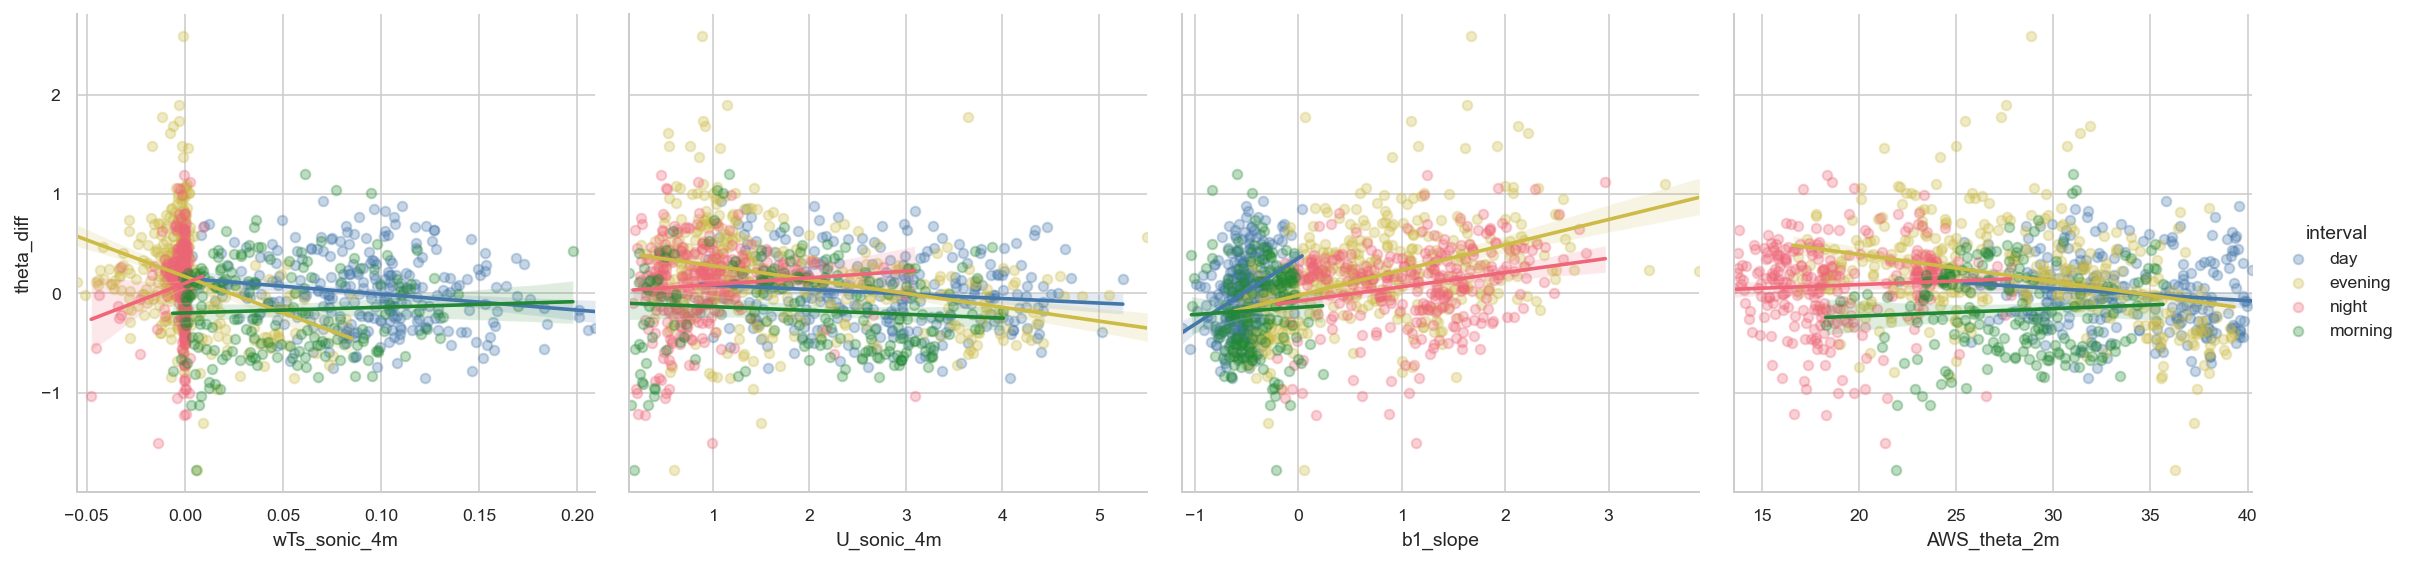

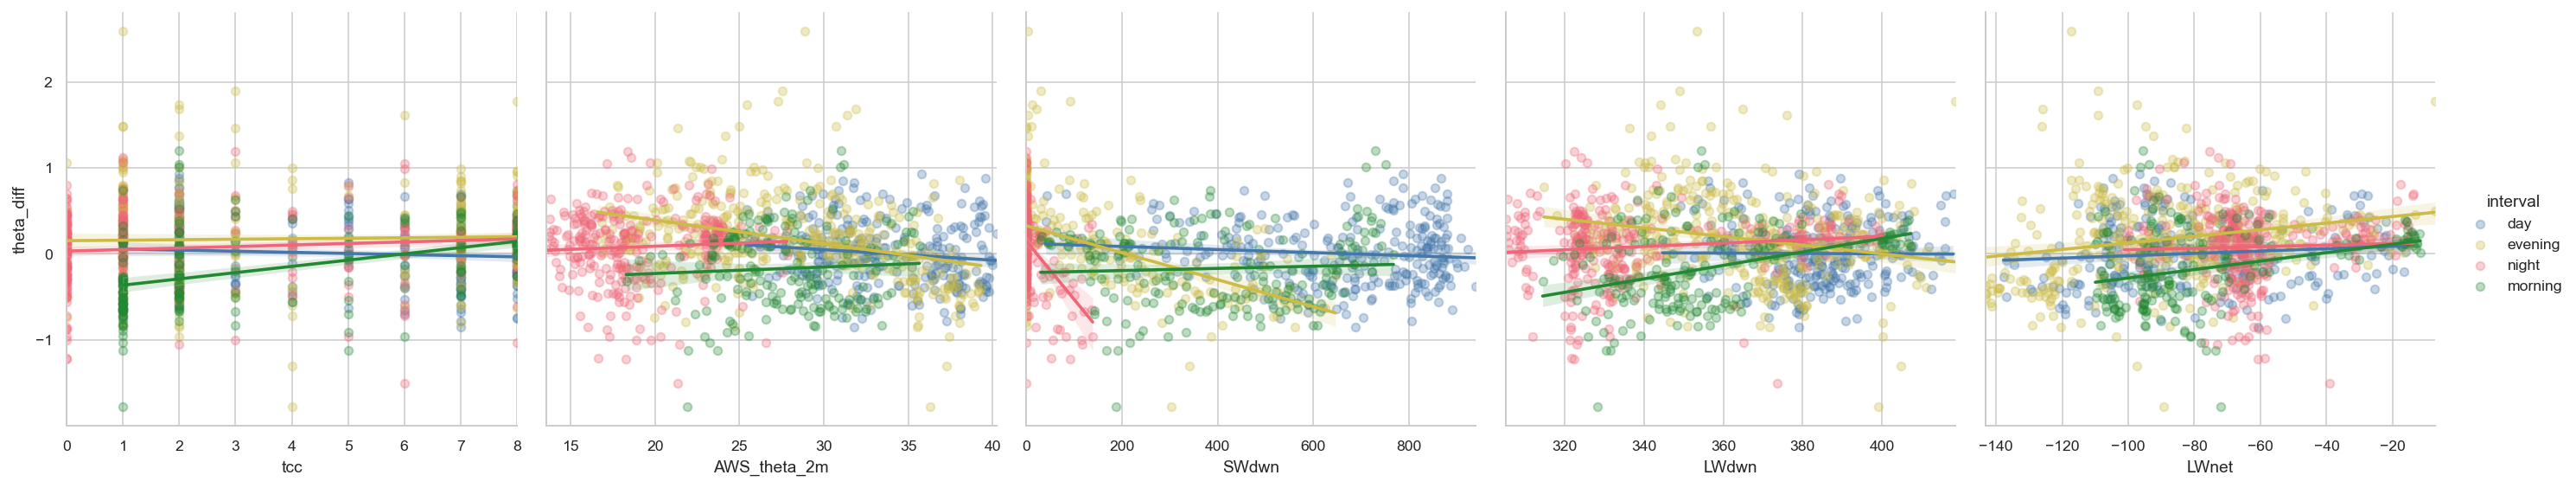

In [17]:
# Turbulence terms
g = sns.PairGrid(
    df_10min,
    y_vars=["theta_diff"],
    x_vars=["wTs_sonic_4m", "U_sonic_4m", 'b1_slope', 'AWS_theta_2m'],
    height=4,
    hue='interval',
)
# g.map(sns.kdeplot, cut=1,)
g.map(sns.regplot, scatter_kws={'alpha':0.3})
g.add_legend()

# Radiation terms
g = sns.PairGrid(
    df_10min,
    y_vars=["theta_diff"],
    x_vars=['tcc', 'AWS_theta_2m', 'SWdwn', 'LWdwn', 'LWnet'],
    height=4,
    hue='interval',
)
# g.map(sns.kdeplot, cut=1, cmap="gray_r")
g.map(sns.regplot, scatter_kws={'alpha': 0.3})
g.add_legend()


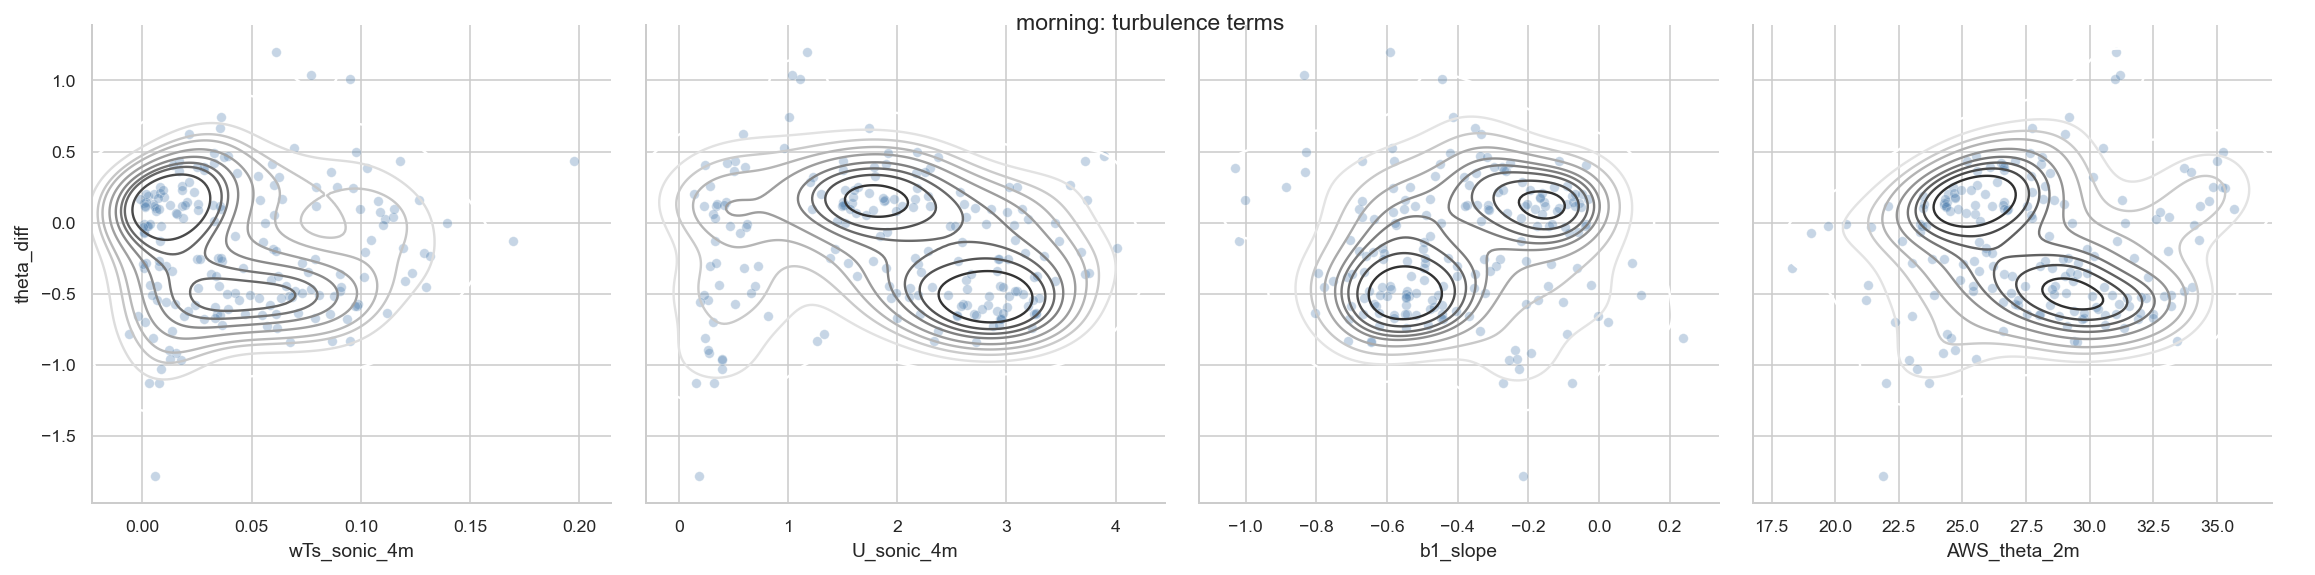

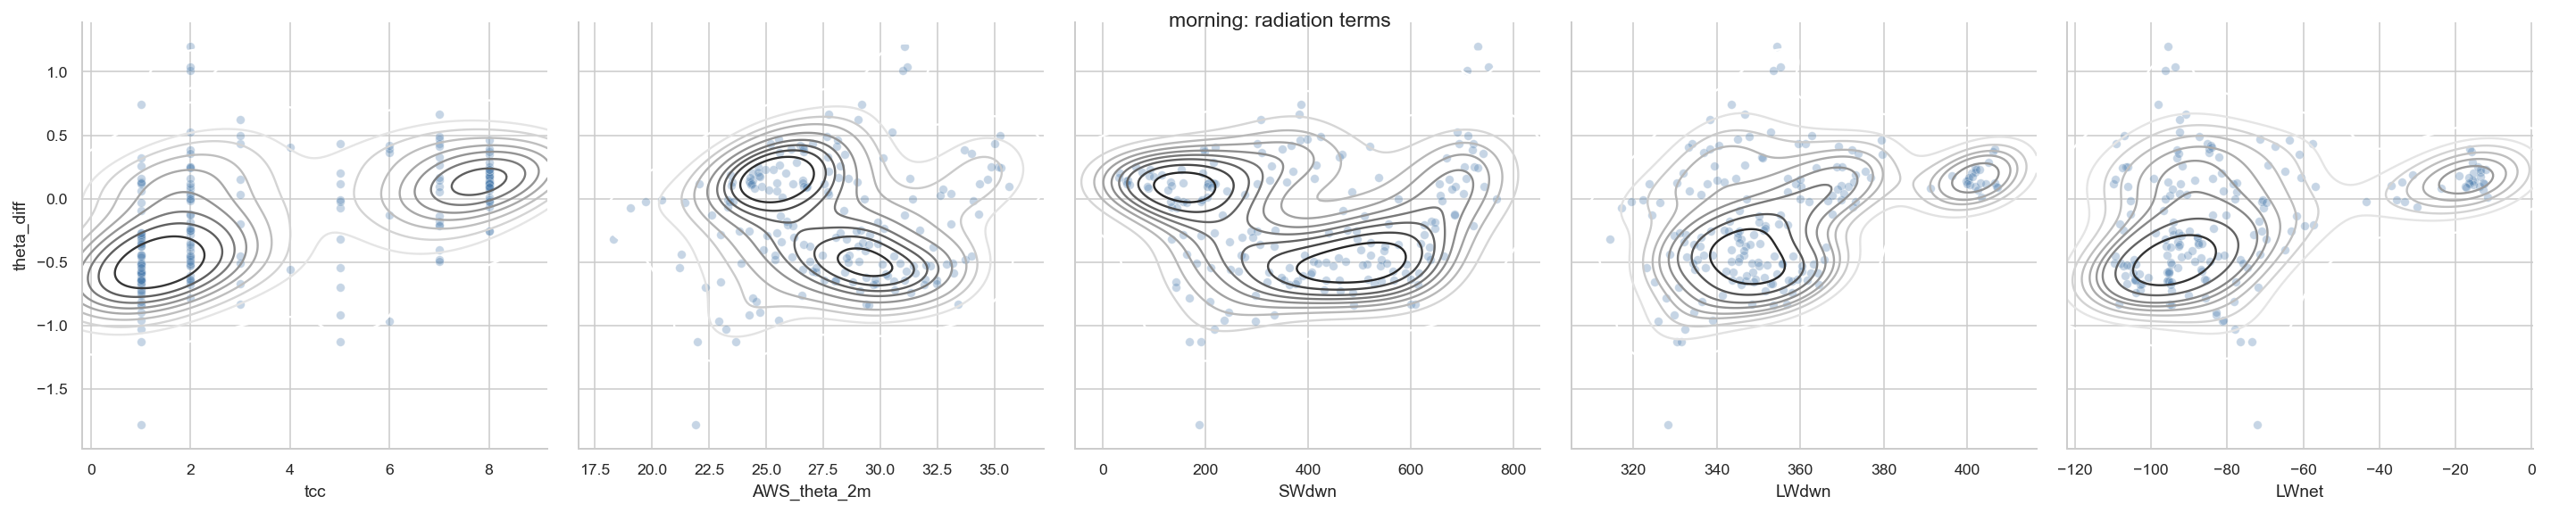

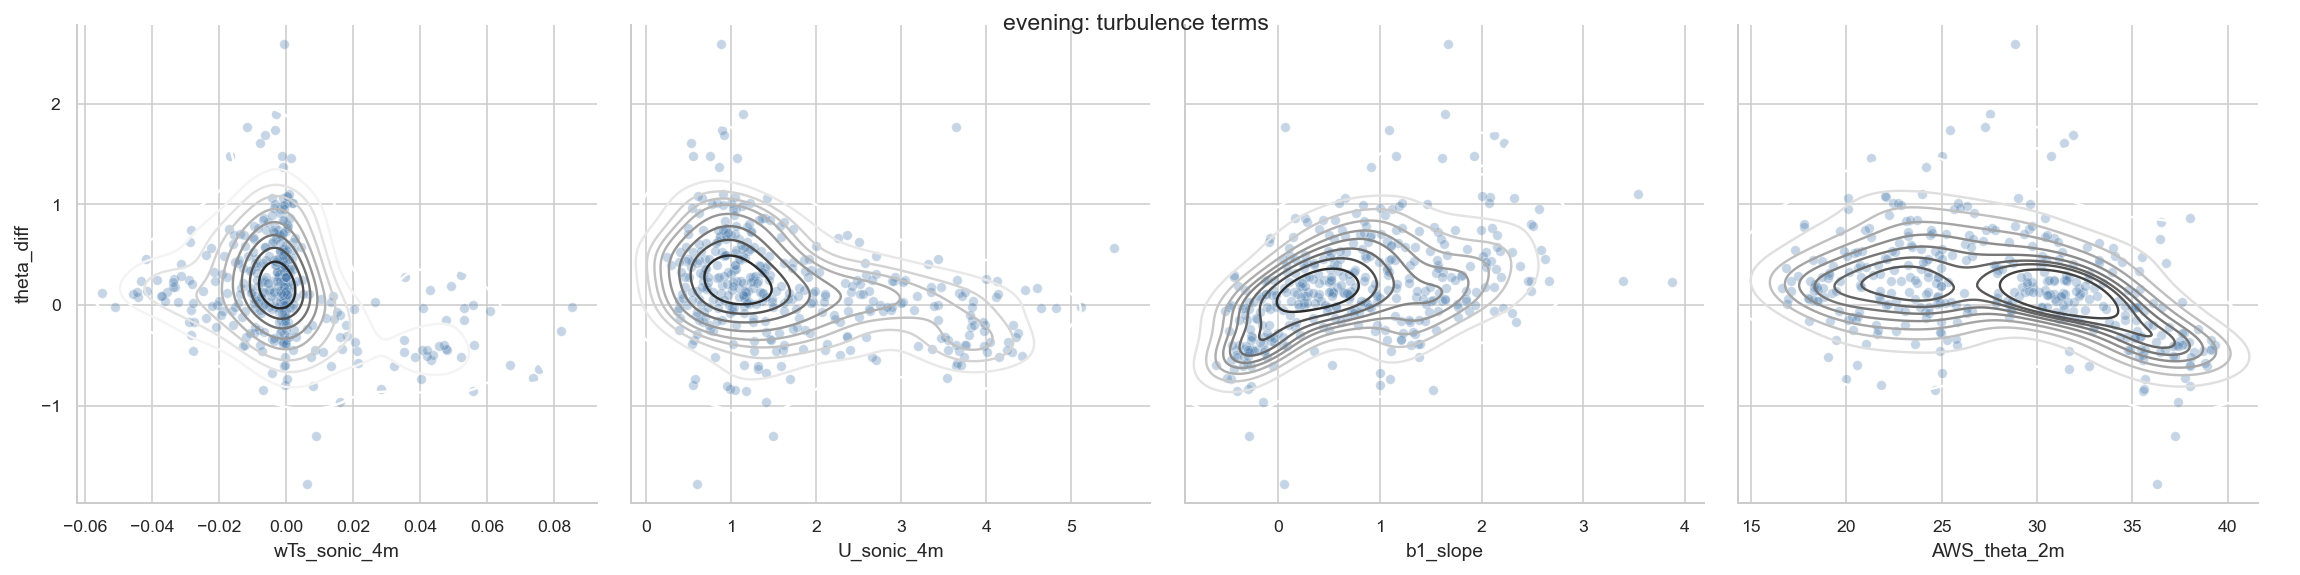

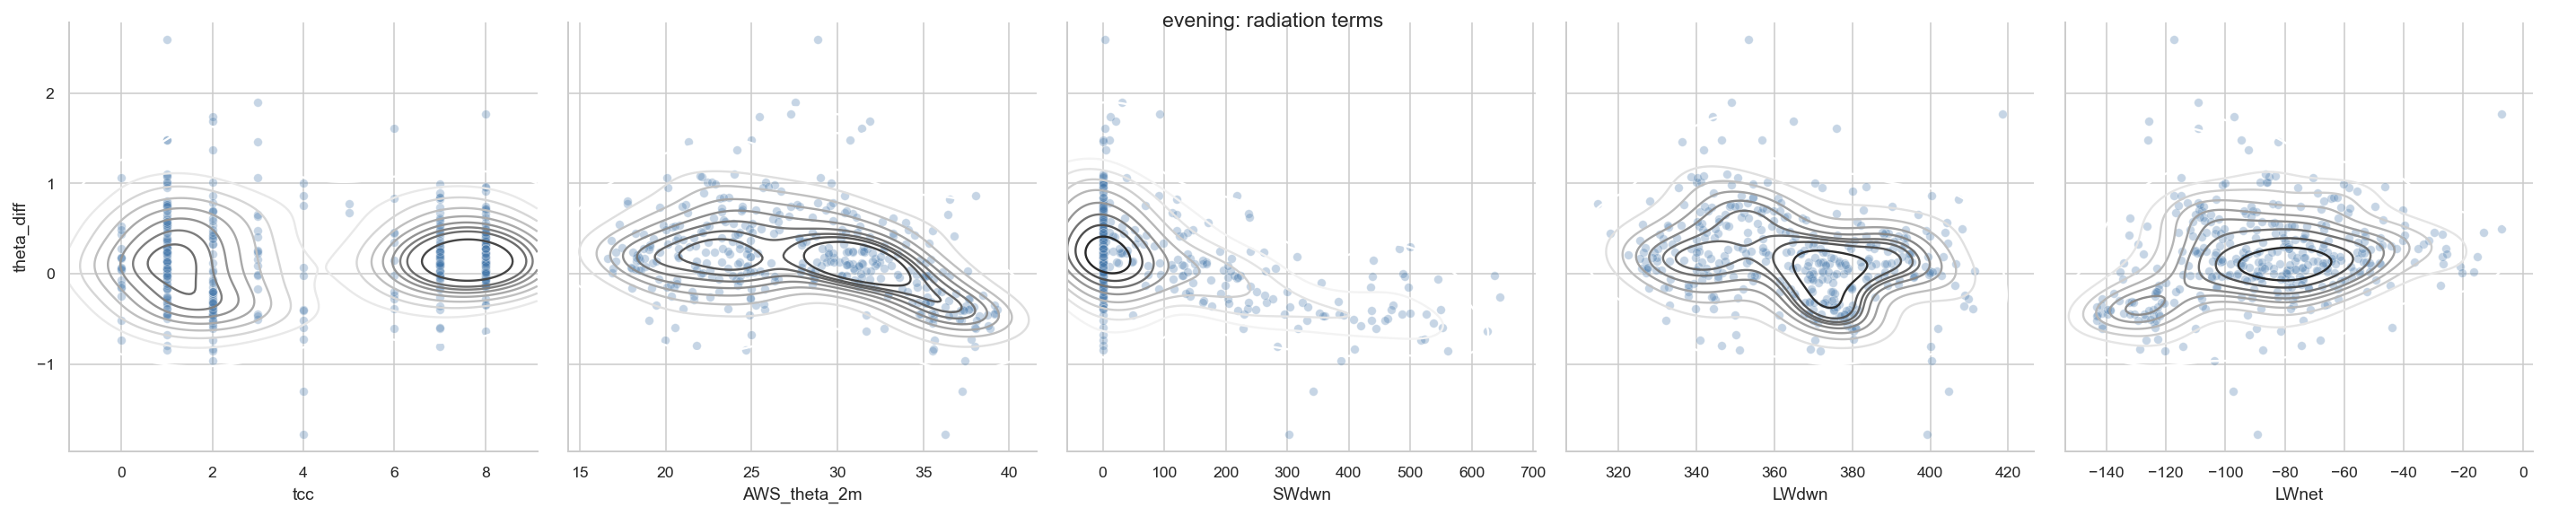

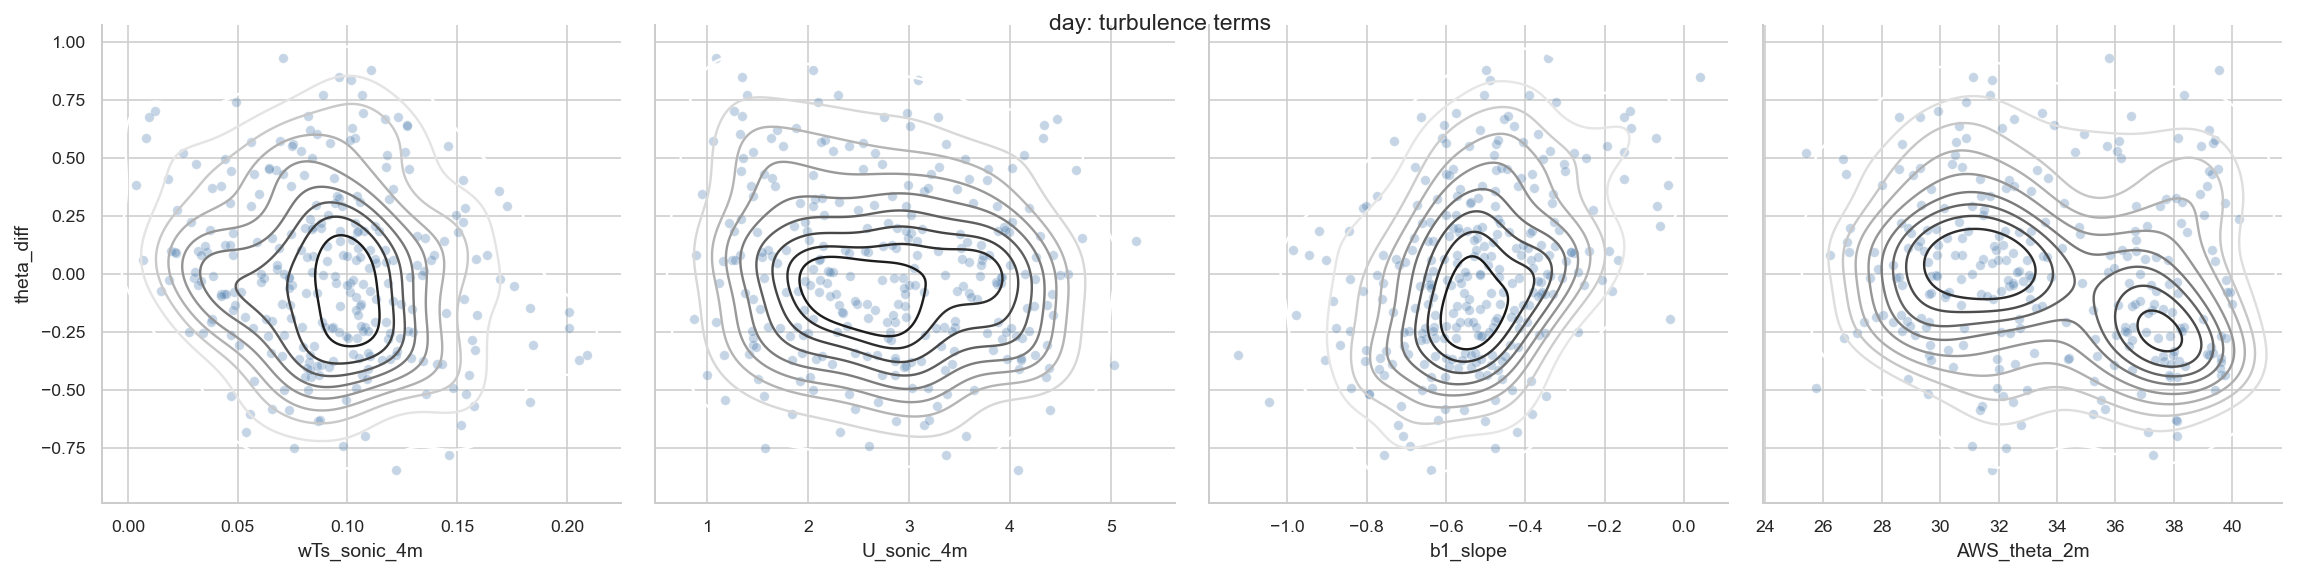

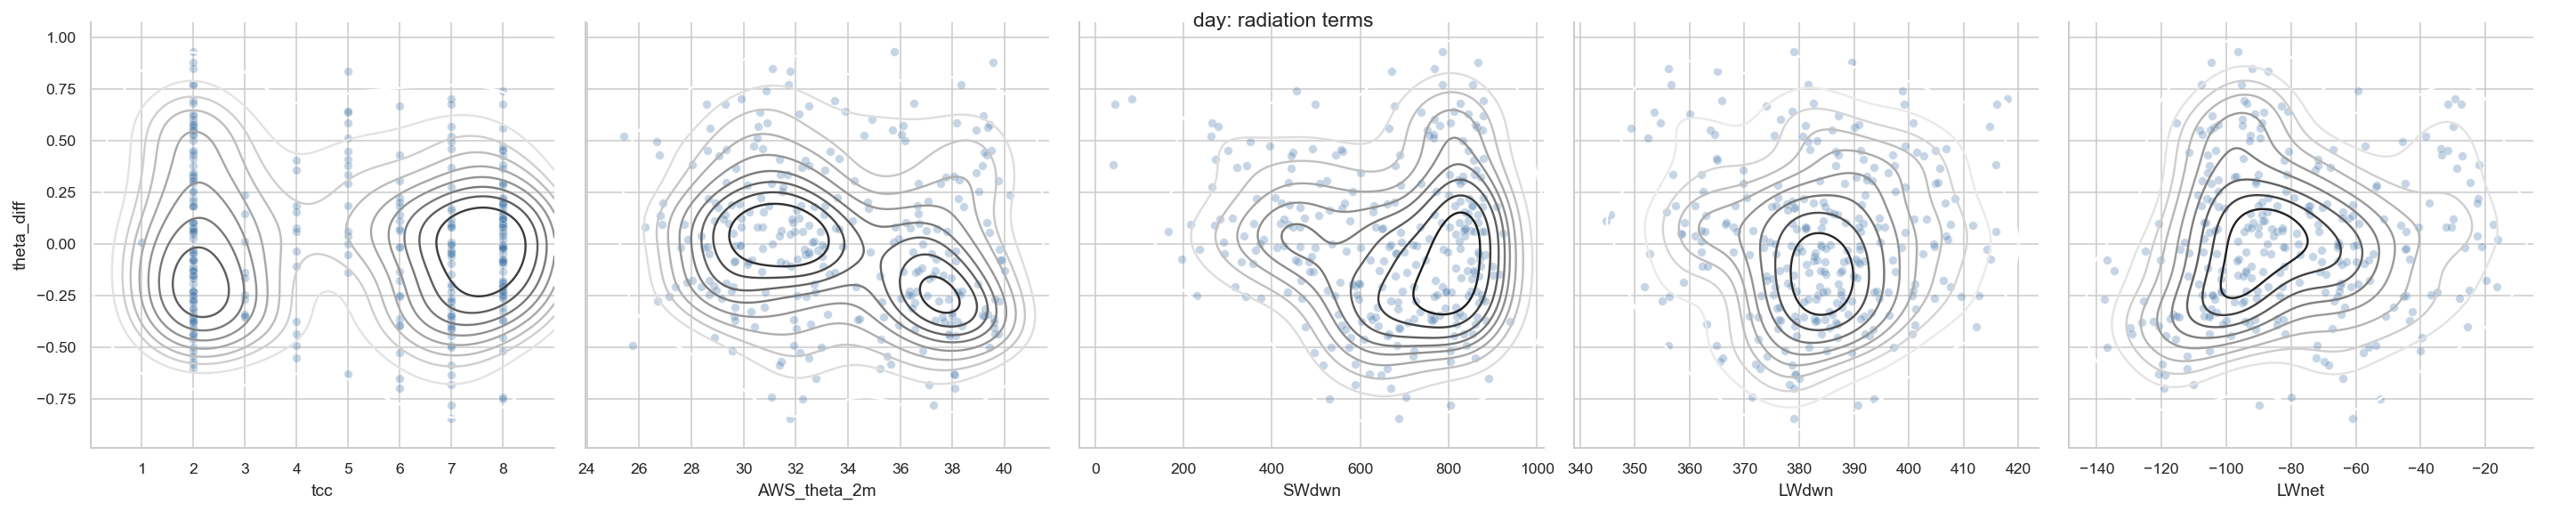

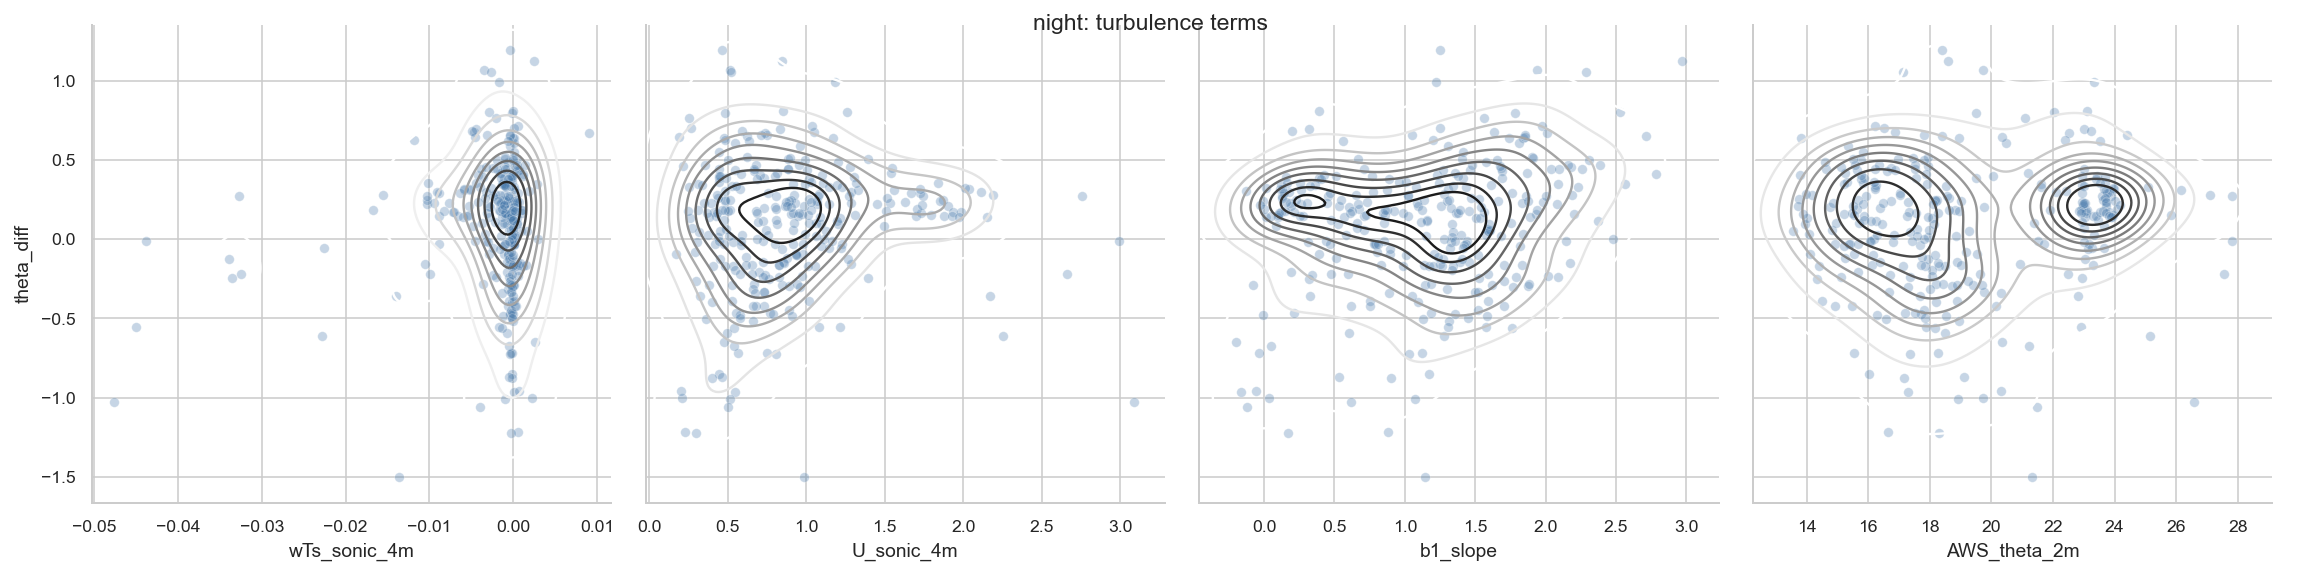

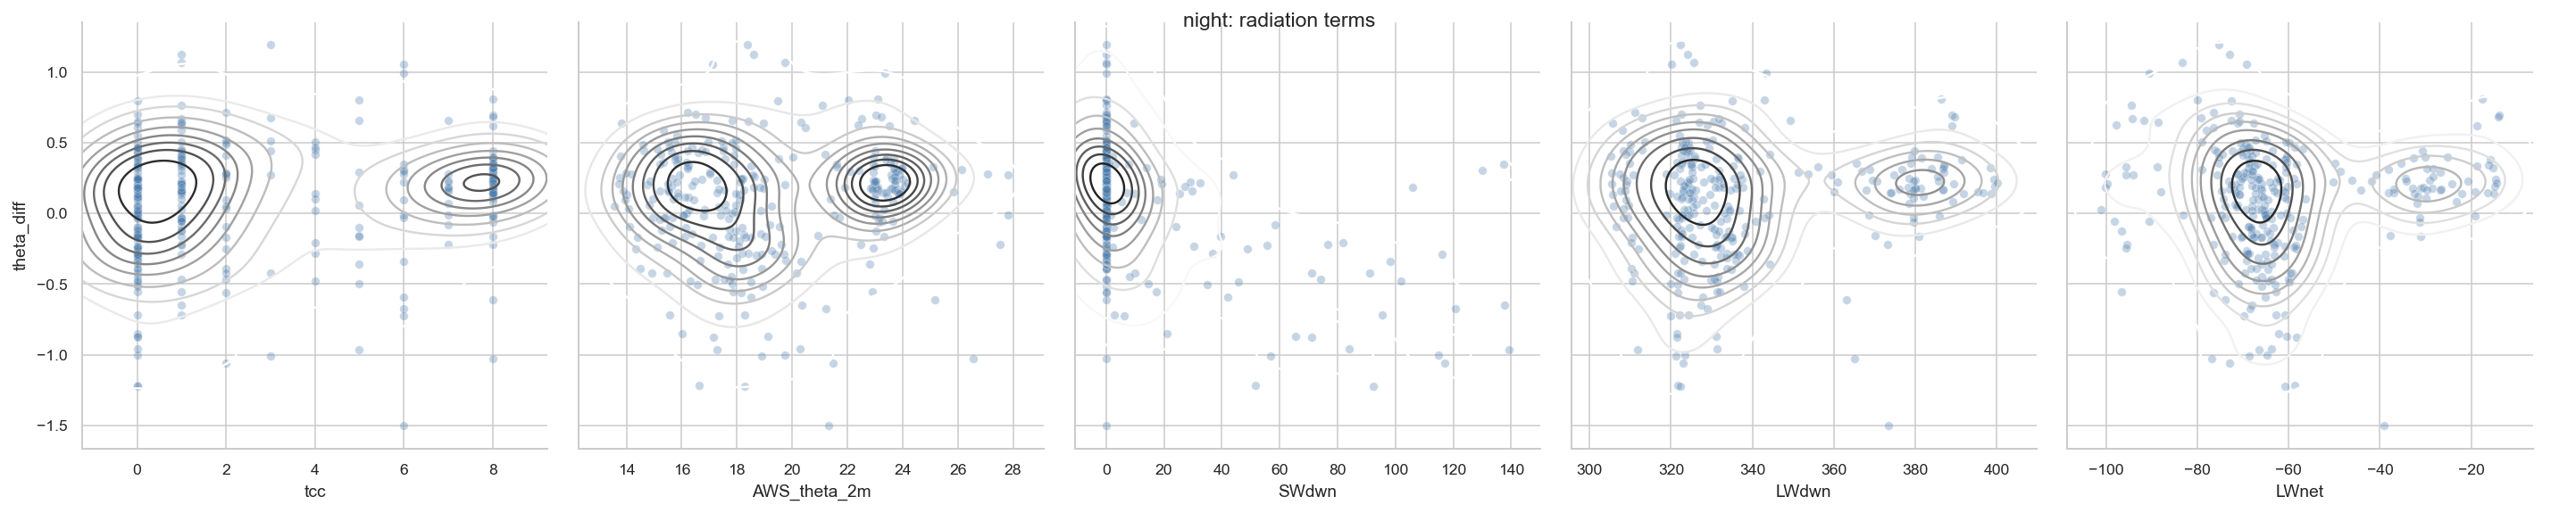

In [18]:
for interval in ['morning', 'evening', 'day', 'night']:
    # Turbulence terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)),
        y_vars=["theta_diff"],
        x_vars=["wTs_sonic_4m", "U_sonic_4m", 'b1_slope', 'AWS_theta_2m'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': turbulence terms')

    # Radiation terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)),
        y_vars=["theta_diff"],
        x_vars=['tcc', 'AWS_theta_2m', 'SWdwn', 'LWdwn', 'LWnet'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')


There are some obvious relationships here, but I believe they may be masked by co-varying physical parameters, e.g. the strong SWdwn corresponds to stronger wind speeds, which counter-act each other in the anticipated artifact on the DTS.

# 6. Dimensionality reduction

There are obvious clusters to make here. These clusters may be powerful for correcting errors in the DTS temperatures and for understanding the impact of typical meteorological observations on the stability, which is a major research question in boundary layer meteorology.

However, the very first step is to provide some dimensionality reduction.

In [32]:
vars_to_sample = ['theta_diff', 'SWdwn', 'LWdwn', 'wTs_sonic_4m', 'U_sonic_4m', 'AWS_theta_2m']

ds_analysis = ds_10min.where(~np.isnan(ds_10min['theta_diff']), drop=True)
sample = [ds_analysis[vts].values for vts in vars_to_sample]
sample = np.array(sample).T

In [33]:
# Apply the scaling (zero mean, variance=1)
sample_scld = StandardScaler().fit_transform(sample)

# PCA of the scaled data
pca = PCA(n_components=len(vars_to_sample))
sample_pca = pca.fit_transform(sample_scld)

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio: [0.5777196  0.17693788 0.12853128 0.07498501 0.03628909 0.00553714]


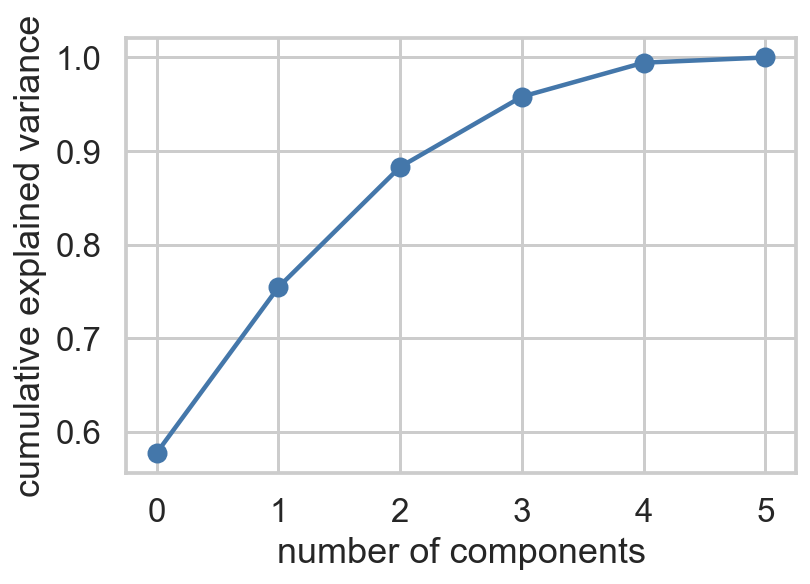

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

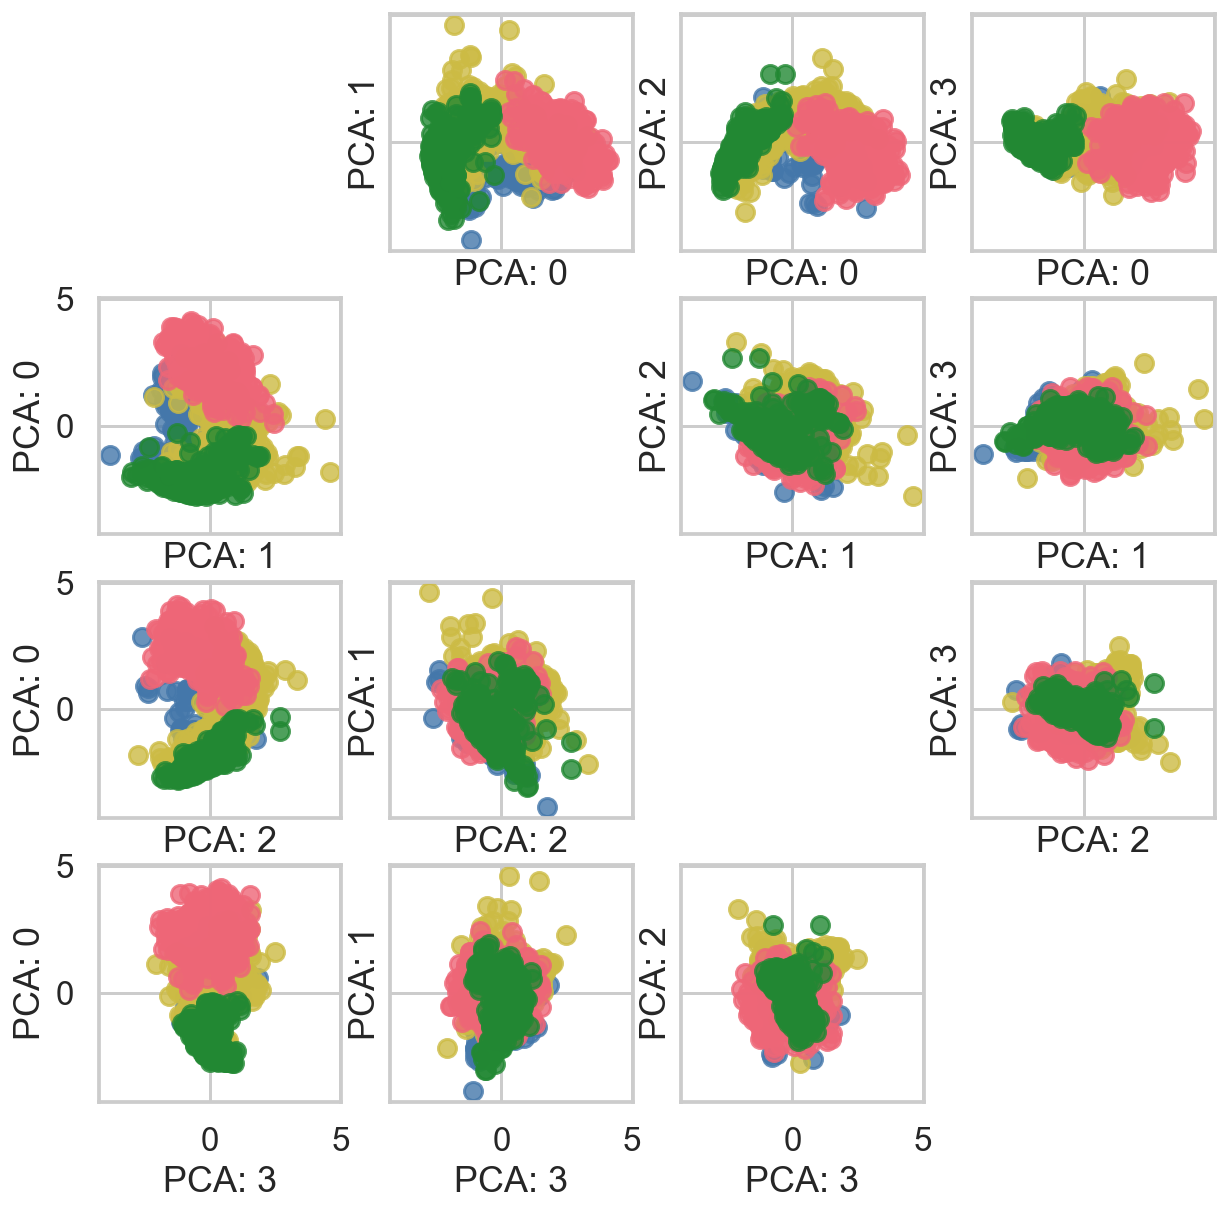

In [35]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)

for ax, (pca1, pca2) in zip(axes.flatten(), list(itertools.product(np.arange(0, 4), np.arange(0, 4)))):
    if pca1 == pca2:
        ax.axis('off')
        continue
    
    for nint, interval in enumerate(['morning', 'evening', 'day', 'night']):
        ind = np.flatnonzero(ds_analysis.interval == interval)
        ax.scatter(
            sample_pca[ind, pca1],
            sample_pca[ind, pca2],
            color=tol_bright_reorder[nint],
            alpha=.8,
        )
    ax.set_xlabel('PCA: {}'.format(pca1))
    ax.set_ylabel('PCA: {}'.format(pca2))

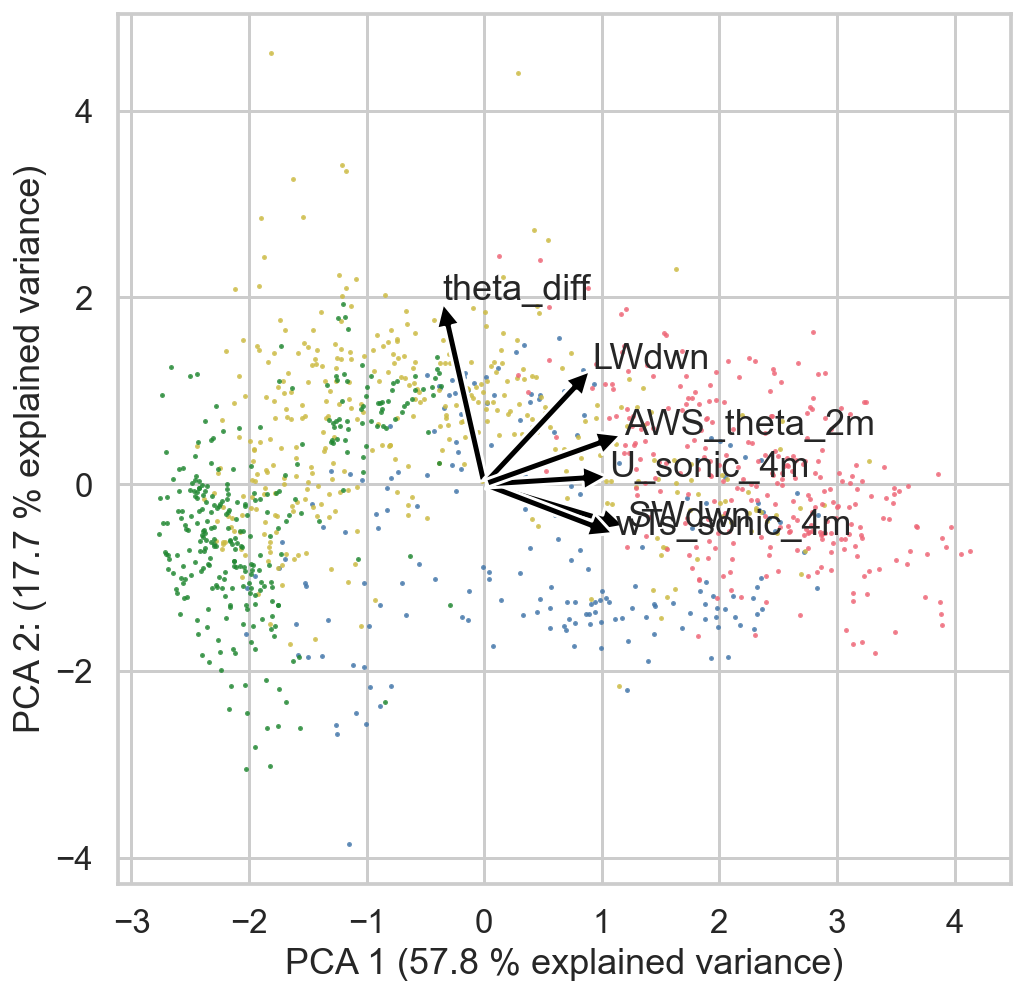

In [36]:
loadings = pca.components_.T
loadings_corr = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
for nint, interval in enumerate(['morning', 'evening', 'day', 'night']):
    ind = np.flatnonzero(ds_analysis.interval == interval)
    ax.scatter(
        sample_pca[ind, 0],
        sample_pca[ind, 1],
        1,
        color=tol_bright_reorder[nint],
        alpha=.8,
    )
ax.set_xlabel('PCA 1 ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 2: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[1] * 100))

for nvar, vts in enumerate(vars_to_sample):
    ax.annotate(
        '',
        xytext=(0, 0), 
        xy=(loadings[nvar, 0] * 2.5, loadings[nvar, 1] * 2.5),
        arrowprops=dict(
            facecolor='black',
            shrink=0.02,
        ),
    )
    
    ax.annotate(
        vts,
        xy=(0, 0), 
        xytext=(loadings[nvar, 0] * 2.5, loadings[nvar, 1] * 2.5),
    )


explained variance ratio: [0.50474417 0.22244185 0.17330834 0.07710933 0.02239631]


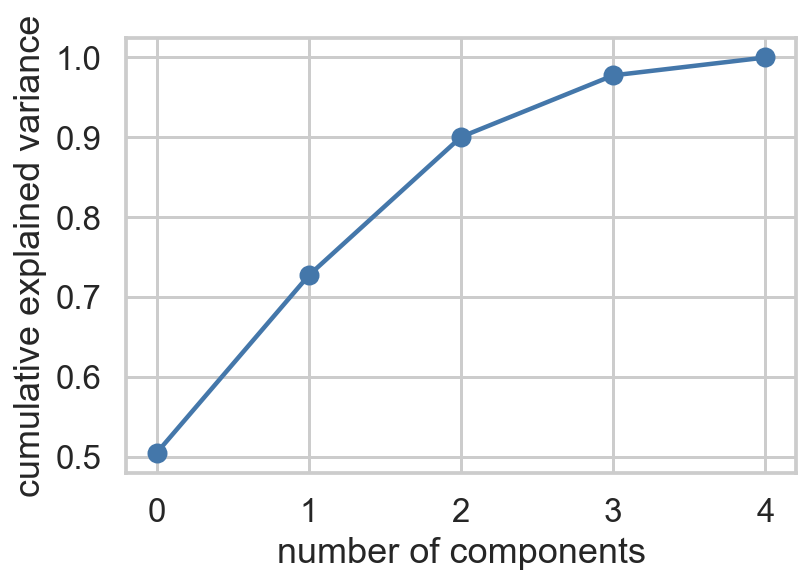

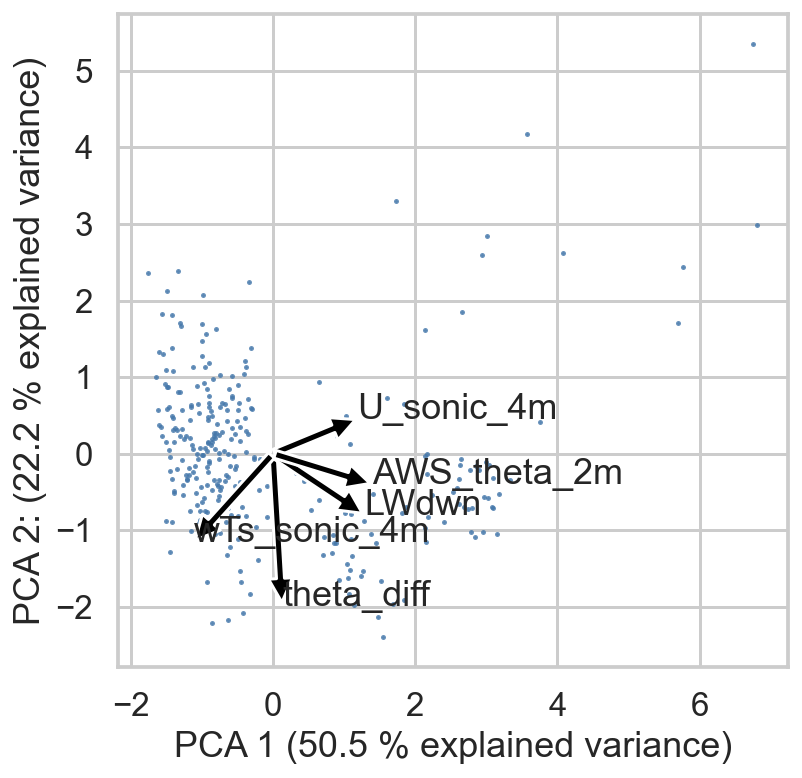

In [38]:
vars_to_sample = ['theta_diff', 'LWdwn', 'wTs_sonic_4m', 'U_sonic_4m', 'AWS_theta_2m']

ds_analysis = ds_10min.where(~np.isnan(ds_10min['theta_diff']), drop=True).where(ds_10min.interval == 'night', drop=True)
sample = [ds_analysis[vts].values for vts in vars_to_sample]
sample = np.array(sample).T

# Apply the scaling (zero mean, variance=1)
sample_scld = StandardScaler().fit_transform(sample)

# PCA of the scaled data
pca = PCA(n_components=len(vars_to_sample))
sample_pca = pca.fit_transform(sample_scld)

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# And the loadings biplot
loadings = pca.components_.T
loadings_corr = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
ax.scatter(
    sample_pca[:, 0],
    sample_pca[:, 1],
    1,
    alpha=.8,
)
ax.set_xlabel('PCA 1 ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 2: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[1] * 100))

for nvar, vts in enumerate(vars_to_sample):
    ax.annotate(
        '',
        xytext=(0, 0), 
        xy=(loadings[nvar, 0] * 2.5, loadings[nvar, 1] * 2.5),
        arrowprops=dict(
            facecolor='black',
            shrink=0.02,
        ),
    )
    
    ax.annotate(
        vts,
        xy=(0, 0), 
        xytext=(loadings[nvar, 0] * 2.5, loadings[nvar, 1] * 2.5),
    )


explained variance ratio: [0.37706122 0.23369924 0.17956955 0.11639536 0.07921989 0.01405475]


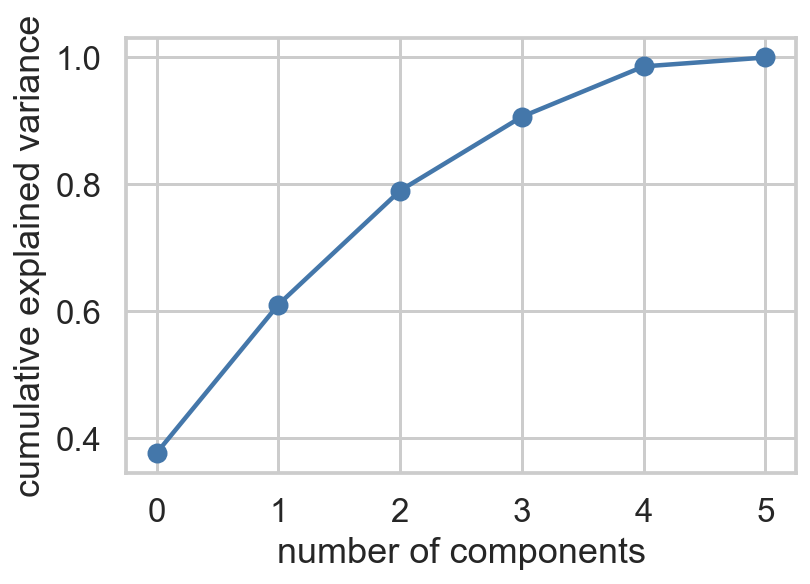

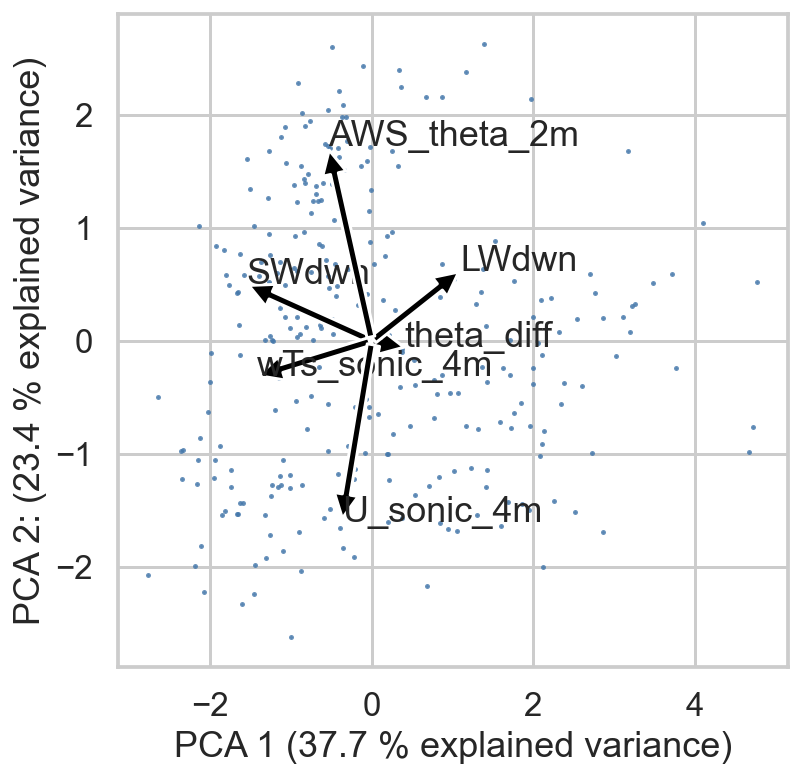

In [39]:
vars_to_sample = ['theta_diff', 'SWdwn', 'LWdwn', 'wTs_sonic_4m', 'U_sonic_4m', 'AWS_theta_2m']

ds_analysis = ds_10min.where(~np.isnan(ds_10min['theta_diff']), drop=True).where(ds_10min.interval == 'day', drop=True)
sample = [ds_analysis[vts].values for vts in vars_to_sample]
sample = np.array(sample).T

# Apply the scaling (zero mean, variance=1)
sample_scld = StandardScaler().fit_transform(sample)

# PCA of the scaled data
pca = PCA(n_components=len(vars_to_sample))
sample_pca = pca.fit_transform(sample_scld)

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# And the loadings biplot
loadings = pca.components_.T
loadings_corr = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
ax.scatter(
    sample_pca[:, 0],
    sample_pca[:, 1],
    1,
    alpha=.8,
)
ax.set_xlabel('PCA 1 ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 2: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[1] * 100))

for nvar, vts in enumerate(vars_to_sample):
    ax.annotate(
        '',
        xytext=(0, 0), 
        xy=(loadings[nvar, 0] * 2.5, loadings[nvar, 1] * 2.5),
        arrowprops=dict(
            facecolor='black',
            shrink=0.02,
        ),
    )
    
    ax.annotate(
        vts,
        xy=(0, 0), 
        xytext=(loadings[nvar, 0] * 2.5, loadings[nvar, 1] * 2.5),
    )


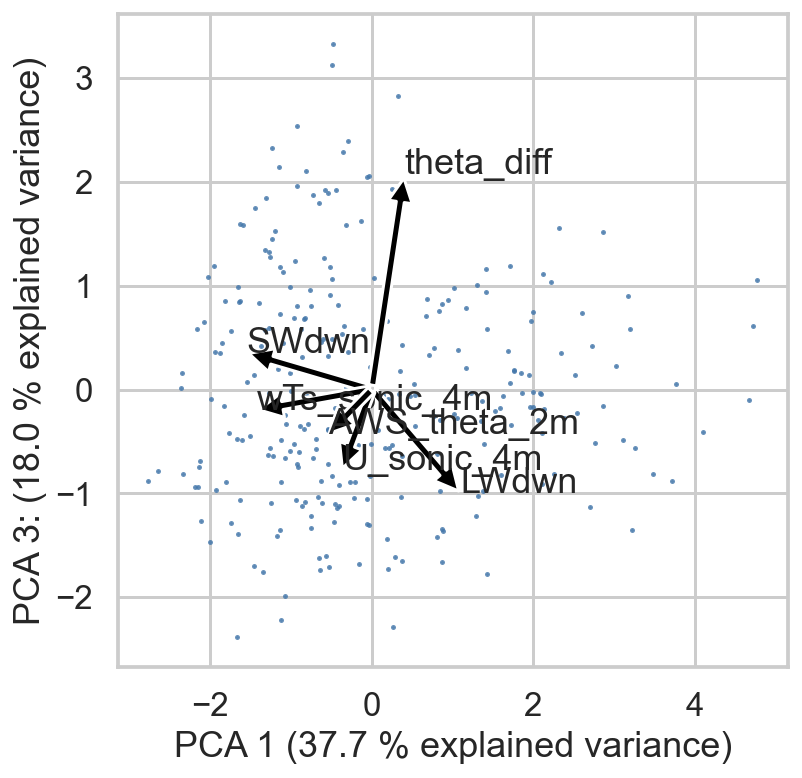

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
ax.scatter(
    sample_pca[:, 0],
    sample_pca[:, 2],
    1,
    alpha=.8,
)
ax.set_xlabel('PCA 1 ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 3: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[2] * 100))

for nvar, vts in enumerate(vars_to_sample):
    ax.annotate(
        '',
        xytext=(0, 0), 
        xy=(loadings[nvar, 0] * 2.5, loadings[nvar, 2] * 2.5),
        arrowprops=dict(
            facecolor='black',
            shrink=0.02,
        ),
    )
    
    ax.annotate(
        vts,
        xy=(0, 0), 
        xytext=(loadings[nvar, 0] * 2.5, loadings[nvar, 2] * 2.5),
    )